# Describing measurements

In [1]:
import numpy as np
import pandas as pd
import sympy

import weldx
import weldx.measurement as msm
import weldx.transformations as tf
from weldx import Q_
from weldx import util

## Overview
In this short example we use welding voltage and current measurements to show how to describe and store measurements with associated measurement chains. This includes describing the measurement equipment and its metadata, describing all the relevant transformation steps from raw-data to the final output and the data itself. The final result is a `MeasurementChain` that should be easy to follow and represent the complete data processing pipeline.

## Generating the measurement data
We start by creating some "dummy" datasets that represent the current and voltage measurements.
In a real application, these would be the datasets that we would copy from our measurement equipment (e.g. downloaded form a HKS-WeldQAS, oscilloscope or similar systems).
The values in these dataset represent the actual physical current and voltage data in A and V.

In [2]:
time = pd.timedelta_range(start="0s", end="10s", freq="1ms")

In [3]:
I_ts = util.sine(f=Q_(10, "1/s"), amp=Q_(20, "A"), bias=Q_(300, "A"))
I = I_ts.interp_time(time)

current_data = weldx.TimeSeries(data=I.data, time=time)
current_data

<TimeSeries>
Time:
	TimedeltaIndex([       '0 days 00:00:00', '0 days 00:00:00.001000',
                '0 days 00:00:00.002000', '0 days 00:00:00.003000',
                '0 days 00:00:00.004000', '0 days 00:00:00.005000',
                '0 days 00:00:00.006000', '0 days 00:00:00.007000',
                '0 days 00:00:00.008000', '0 days 00:00:00.009000',
                ...
                '0 days 00:00:09.991000', '0 days 00:00:09.992000',
                '0 days 00:00:09.993000', '0 days 00:00:09.994000',
                '0 days 00:00:09.995000', '0 days 00:00:09.996000',
                '0 days 00:00:09.997000', '0 days 00:00:09.998000',
                '0 days 00:00:09.999000',        '0 days 00:00:10'],
               dtype='timedelta64[ns]', length=10001, freq=None)
Values:
	[300.         301.25581039 302.50666467 ... 297.49333533 298.74418961
 300.        ]
Interpolation:
	linear
Units:
	ampere

In [4]:
U_ts = util.sine(f=Q_(10, "1/s"), amp=Q_(3, "V"), bias=Q_(40, "V"), phase=Q_(0.1, "rad"))
U = U_ts.interp_time(time)

voltage_data = weldx.TimeSeries(data=U.data, time=time)
voltage_data

<TimeSeries>
Time:
	TimedeltaIndex([       '0 days 00:00:00', '0 days 00:00:00.001000',
                '0 days 00:00:00.002000', '0 days 00:00:00.003000',
                '0 days 00:00:00.004000', '0 days 00:00:00.005000',
                '0 days 00:00:00.006000', '0 days 00:00:00.007000',
                '0 days 00:00:00.008000', '0 days 00:00:00.009000',
                ...
                '0 days 00:00:09.991000', '0 days 00:00:09.992000',
                '0 days 00:00:09.993000', '0 days 00:00:09.994000',
                '0 days 00:00:09.995000', '0 days 00:00:09.996000',
                '0 days 00:00:09.997000', '0 days 00:00:09.998000',
                '0 days 00:00:09.999000',        '0 days 00:00:10'],
               dtype='timedelta64[ns]', length=10001, freq=None)
Values:
	[40.29950025 40.48633974 40.67125987 ... 39.92301733 40.11147877
 40.29950025]
Interpolation:
	linear
Units:
	volt

> todo: rewrite after discussing this with the group

It is important to note the type and structure of the `current_data` and `voltage_data` datasets:

- they are created as `xarray.DataArrays`
- the data itself is a `pint.Quantity` i.e. a numpy array with associated unit. For the current measurement this is `ampere`, the voltage is given in `volt`. Using quantities is an important core concept of measurements !
- each `DataArray` has a `time` dimension and coordinate using numpy datetime formats.

## Equipment and Software
Next, let's define some of the equipment and software that is used throughout the measurement chain. We will use and add more information to these objects later.

In out example, two types of hardware equipment are used:

- The [`HKS P1000-S3`](https://hks-prozesstechnik.de/en/sensors-2/) is a standard welding process sensor that detects the welding voltage and current using a hall sensor. The result is output as two analog signals scaled to +/- 10 V.
- The [`Beckhoff ELM3002-0000`](https://www.beckhoff.com/ELM3002/) is a fieldbus AD-converter terminal that picks up the analog signals of the HKS Sensor and transmits them digitally to the control software.

The final piece involved in the measurement chain is the Software used to record, scale and save both the welding current and voltage measurements. We define the software version and name used during the example using built-in ASDF types.

In [5]:
HKS_sensor = msm.MeasurementEquipment(name="HKS P1000-S3")

BH_ELM = msm.MeasurementEquipment(name="Beckhoff ELM3002-0000")

In [6]:
from asdf.tags.core import Software

twincat_scope = Software(name="Beckhoff TwinCAT ScopeView", version="3.4.3143")

## Defining a measurement chain: current measurement
Now we define the missing elements of our measurement chain and bundle everything together. A core concept of the chain are `signals` that go in and out of `transformations` which define mathematical operations of the signals, forming the chain.

Each measurement chain starts with a source signal. This is the point where our physical process or quantity is initially detected by a sensor. Since every `MeasurementChain` needs at least a source, we need to provide the corresponding information when creating an instance of this class. The parameters are the `source_name`, the `output_signal_type` and `output_signal_unit` as well as the `source_error` representing the uncertainty attached to the signal source. 

For our current measurement, the source outputs an **analog Signal** of unit **V**. Since there is no recording of this measurement we do not provide the data. According to the spec sheet of the sensor the measurement error in this initial step is **0.1 %** which can be documented using the `Error` property (again using quantities).

In [7]:
welding_current_chain = msm.MeasurementChain.from_parameters(
    name="welding current measurement chain",
    source_name="Current Sensor",
    output_signal_type="analog", 
    output_signal_unit="V",
    source_error=msm.Error(Q_(0.1, "percent")),
)

We associate the current measurement source with the HKS sensor by adding it to its list of sources. We now have the start of our measurement chain defined.

In [8]:
#HKS_sensor.sources = []
#HKS_sensor.sources.append(src_current)

The next step in the chain is picking up the analog voltage signal from our source with the Beckhoff AD converter terminal which transform the signal into an internal signed integer value. The formula describing this linear transformation with input `x` is
```
a * x + b
32768 / (10 V) * x  + 0
```
We express this signal transformation as an analytical formula created with the `sympy` package. Based on the above formula we also define the static parameters `a` and `b` in the `MathematicalExpression`. Note that we use quantities here as well !
Since our result is a dimensionless integer `a` has the unit **1/V** and `b` is dimensionless which we indicate with `""`.

In [9]:
from weldx.asdf.tags.weldx.core.mathematical_expression import MathematicalExpression

[a, x, b] = sympy.symbols("a x b")
current_AD_func = MathematicalExpression(a * x + b)
current_AD_func.set_parameter("a", Q_(32768.0 / 10.0, "1/V"))
current_AD_func.set_parameter("b", Q_(0.0, ""))

Now that we have the transform function we can define our `DataTransformation`. The `input_signal` of our transformation is the `src_current.output_signal` object from our source signal defined earlier.
Our new Transformation outputs a new **dimensionless** signal of type **digital**. Once again, since we have no data record of this we do not assign any data object to the signal. The Beckhoff AD converter lists the measurement Error at **0.01 %**.

In [10]:
#current_AD_transform = msm.DataTransformation(
#    name="AD conversion current measurement",
#    input_signal=src_current.output_signal,
#    output_signal=msm.Signal("digital", "", data=None),
#    error=msm.Error(Q_(0.01, "percent")),
#    func=current_AD_func,
#)
welding_current_chain.create_transformation(
    name="AD conversion current measurement",
    output_signal_type="digital",
    output_signal_unit="",
    error=msm.Error(Q_(0.01, "percent")),
    func=current_AD_func                
)


We also associate the transformation to the Beckhoff equipment:

In [11]:
# BH_ELM.data_transformations = []
# BH_ELM.data_transformations.append(current_AD_transform)

Similar to the AD conversion, we add the final step of our signal processing chain: digitally converting the signal to the final physical representation of the welding current. The current calibration formula from our integer values to the real current values is as follows:
```
1000 A / 32768 * x  + 0 A
```
Put into a new `sympy` expression:

In [12]:
# define current output calibration expression and transformation
current_calib_func = MathematicalExpression(a * x + b)
current_calib_func.set_parameter("a", Q_(1000.0 / 32768.0, "A"))
current_calib_func.set_parameter("b", Q_(0.0, "A"))

We create the final transformation step:

- the input signal now is the output signal of the previous AD conversion
- the output signal is our final current measurement representation
- we add the our measurement data to this signal !
- we add the software as a meta field to the signal transformation

In [13]:
#current_calib_transform = msm.DataTransformation(
#    name="Calibration current measurement",
#    input_signal=current_AD_transform.output_signal,
#    output_signal=msm.Signal("digital", "A", data=current_data),
#    error=msm.Error(0.0),
#    func=current_calib_func,
#    meta=twincat_scope,
#)

# todo:
# - add signal data parameter?
# - add meta data
welding_current_chain.create_transformation(
    name="Calibration current measurement",
    output_signal_type="digital",
    output_signal_unit="A",
    error=msm.Error(0.0),
    func=current_calib_func
)
welding_current_chain.add_signal_data(current_data)

Now that our `MeasurementChain` is complete, we can visualize it using its `plot` function.

<AxesSubplot:title={'center':'welding current measurement chain'}>

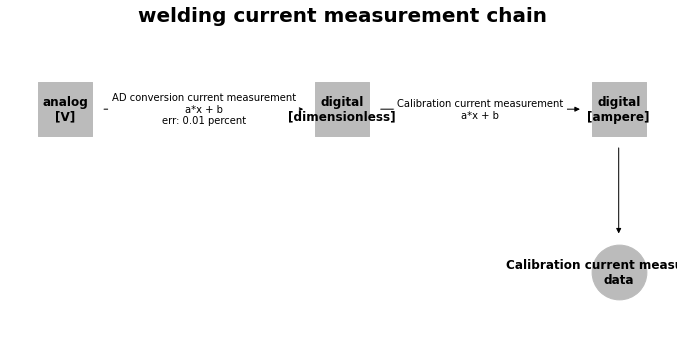

In [14]:
welding_current_chain.plot()

Finally the `Measurement` is our measurement chain with another link to the data.

In [15]:
welding_current = msm.Measurement(
    name="welding current measurement",
    data=[current_data],
    measurement_chain=welding_current_chain,
)

## voltage measurement
We follow the same procedure described in the current measurement here :-)

<AxesSubplot:title={'center':'welding voltage measurement'}>

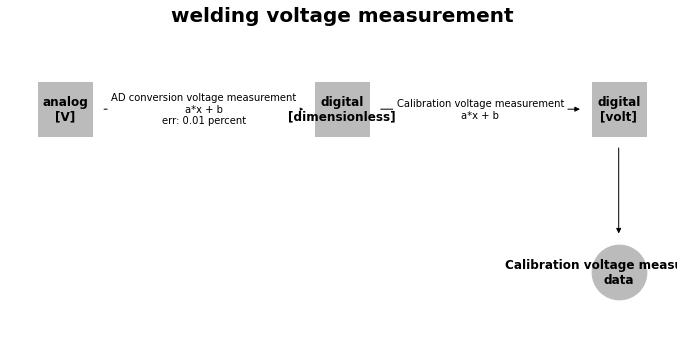

In [16]:
welding_voltage_chain = msm.MeasurementChain.from_parameters(
    name="welding voltage measurement",
    source_name="Voltage Sensor",
    output_signal_type="analog",
    output_signal_unit="V",
    source_error=msm.Error(Q_(0.1, "percent"))
) 

#HKS_sensor.sources.append(src_voltage)

# define AD conversion expression and transformation step
[a, x, b] = sympy.symbols("a x b")
voltage_ad_func = MathematicalExpression(a * x + b)
voltage_ad_func.set_parameter("a", Q_(32768.0 / 10.0, "1/V"))
voltage_ad_func.set_parameter("b", Q_(0.0, ""))

#voltage_AD_transform = msm.DataTransformation(
#    name="AD conversion voltage measurement",
#    input_signal=src_voltage.output_signal,
#    output_signal=msm.Signal("digital", "", data=None),
#    error=msm.Error(Q_(0.01, "percent")),
#    func=voltage_ad_func,
#)

welding_voltage_chain.create_transformation(
    name="AD conversion voltage measurement",
    output_signal_type="digital",
    output_signal_unit="",
    error=msm.Error(Q_(0.01, "percent")),
    func=voltage_ad_func
)

#HKS_sensor.data_transformations.append(voltage_AD_transform)

# define voltage output calibration expression and transformation
voltage_calib_func = MathematicalExpression(a * x + b)
voltage_calib_func.set_parameter("a", Q_(100.0 / 32768.0, "V"))
voltage_calib_func.set_parameter("b", Q_(0.0, "V"))

#voltage_calib_transform = msm.DataTransformation(
#    name="Calibration voltage measurement",
#    input_signal=voltage_AD_transform.output_signal,
#    output_signal=msm.Signal("digital", "V", data=voltage_data),
#    error=msm.Error(0.0),
#    func=voltage_calib_func,
#    meta=twincat_scope,
#)

# todo: add meta
welding_voltage_chain.create_transformation(
    name="Calibration voltage measurement",
    output_signal_type="digital",
    output_signal_unit="V",
    error=msm.Error(0.0),
    func=voltage_calib_func
)
welding_voltage_chain.add_signal_data(voltage_data)

#welding_voltage_chain = msm.MeasurementChain(
#    name="welding voltage measurement chain",
#    data_source=src_voltage,
#    data_processors=[voltage_AD_transform, voltage_calib_transform],
#)

welding_voltage = msm.Measurement(
    name="welding voltage measurement",
    data=[voltage_data],
    measurement_chain=welding_voltage_chain,
)
welding_voltage_chain.plot()

## Coordinate Systems

Most data does not make much sense without being able to determine where it was recorded in relation to a specimen or other measurement spots. Therefore, we define coordinate systems and their orientations towards each other. The basic principles are already explained in the transformation tutorials, so we will just define some coordinate systems without further explanation. To keep things simple, no time dependent coordinates are considered.

In [17]:
lcs_specimen_in_root = tf.LocalCoordinateSystem(
    coordinates=Q_(np.asarray([100, 75, 0]), "mm")
)
lcs_flange_in_root = tf.LocalCoordinateSystem(
    orientation=tf.WXRotation.from_euler("x",np.pi / 2).as_matrix(),
    coordinates=Q_(np.asarray([115, -10, 140]), "mm"),
)
lcs_torch_in_flange = tf.LocalCoordinateSystem(
    coordinates=Q_(np.asarray([100, 75, 0]), "mm")
)

coordinate_systems = tf.CoordinateSystemManager("root")
coordinate_systems.add_cs("specimen", "root", lcs_specimen_in_root)
coordinate_systems.add_cs("flange", "root", lcs_flange_in_root)
coordinate_systems.add_cs("torch", "flange", lcs_torch_in_flange)

> **TODO:** Connect data to coordinate systems

## Writing to ASDF
Once we have define all object we can write them to a ASDF file. To make the file easier to read we place some elements earlier in the tree.

In [18]:
equipment = [HKS_sensor, BH_ELM]
measurement_data = [current_data, voltage_data]
measurements = [welding_current, welding_voltage]

tree = {
    #"coordinate_systems": coordinate_systems,
    "equipment": equipment,
    "data": measurement_data,
    "measurements": measurements,
    # "expression": expr_01,
    # "measurement_chains": measurement_chains,
    # "data_sources": sources,
    # "data_processors": processors,
}
buffer = weldx.asdf.util._write_buffer(tree)

In [19]:
weldx.asdf.util.notebook_fileprinter(buffer)

In [20]:
data = weldx.asdf.util._read_buffer(buffer)